In [ ]:
!pip install transformers rouge-score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7711339785dc1aa705c9a8ec3267c61fae292fb49f5b42627841f19449b070ea
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from bert_score import score as bert_score

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
model_name = "cahya/t5-base-indonesian-summarization-cased"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [ ]:
# File paths
file_paths = {
    'train': '/kaggle/input/dataset-lowercase-clean/train_data (1).csv',
    'test': '/kaggle/input/dataset-lowercase-clean/test_data (1).csv',
    'val': '/kaggle/input/dataset-lowercase-clean/val_data.csv'
}

# Fungsi untuk membaca dan melakukan tokenisasi pada data
def process_data(file_path):
    # Membaca CSV
    data = pd.read_csv(file_path)

    # Mengganti NaN dengan string kosong agar tokenizer bisa bekerja dengan data yang valid
    data['content'] = data['content'].fillna('')
    data['summary'] = data['summary'].fillna('')

    # Tokenisasi kolom 'content' dan 'summary' dengan padding dan attention mask otomatis
    input_encodings = tokenizer(
        data['content'].tolist(),
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    target_encodings = tokenizer(
        data['summary'].tolist(),
        max_length=150,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )

    # Menambahkan kolom tokenisasi ke DataFrame
    data['input_ids'] = input_encodings['input_ids'].tolist()
    data['attention_mask'] = input_encodings['attention_mask'].tolist()
    data['labels'] = target_encodings['input_ids'].tolist()

    # Menampilkan beberapa baris pertama setelah tokenisasi
    return data[['content', 'summary', 'input_ids', 'attention_mask', 'labels']]

# Proses data untuk train, test, dan val
train_data = process_data(file_paths['train'])
test_data = process_data(file_paths['test'])
val_data = process_data(file_paths['val'])

# Tampilkan hasil tokenisasi sebagai DataFrame tanpa print
train_data.head()  # Tampilkan 5 baris pertama dari data pelatihan

,content,summary,input_ids,attention_mask,labels
0,"ketua dewan pimpinan wilayah psi jakarta, elva...",psi menargetkan ridwan kamil-suswono menang sa...,"[1103, 2759, 2000, 180, 15, 9655, 15, 19704, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 9655, 24928, 15, 6476, 1517, 328, 363, 7,..."
1,pt pelayaran nasional indonesia (persero) atau...,pt pelni (persero) sedang membuka lowongan ker...,"[15, 6091, 8020, 2030, 15, 27478, 15, 4, 912, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 6091, 15, 3979, 794, 15, 4, 912, 25, 4671..."
2,shahnaz haque bercerita tentang kronologi meni...,"adik marissa haque, shahnaz haque mengungkapka...","[15, 14138, 13785, 5419, 3289, 16852, 406, 222...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2811, 8268, 8967, 13, 5419, 3289, 14, 15, 141..."
3,bank indonesia (bi) mengajak investor china me...,bi mengajak investor china memanfaatkan peluan...,"[1536, 15, 27478, 15, 4, 901, 5, 6024, 8562, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3543, 6024, 8562, 15, 10093, 13, 2787, 678, 5..."
4,ketua bidang pelayanan pusat kedokteran dan ke...,pusdokkes polri masih kesulitan mengidentifika...,"[1103, 399, 14041, 461, 30, 6734, 778, 36, 16,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[15, 5998, 6734, 2637, 15, 5001, 572, 145, 797..."


In [ ]:
train_data.to_csv('train_data_tokenized_indot5.csv', index=False)
test_data.to_csv('test_data_tokenized_indot5.csv', index=False)
val_data.to_csv('val_data_tokenized_indot5.csv', index=False)

In [ ]:
# Dataset Class (menggunakan token yang sudah ada)
class SummaryDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.data.iloc[idx]['input_ids']),
            'attention_mask': torch.tensor(self.data.iloc[idx]['attention_mask']),
            'labels': torch.tensor(self.data.iloc[idx]['labels'])
        }

# Membuat dataset untuk train, validation, dan test set
train_dataset = SummaryDataset(train_data)
val_dataset = SummaryDataset(val_data)
test_dataset = SummaryDataset(test_data)

# Membuat DataLoader untuk batch training
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("cahya/t5-base-indonesian-summarization-cased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
from transformers import AdamW

# Menggunakan Adam optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Tentukan jumlah epoch untuk pelatihan
num_epochs = 10

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch

train_losses_per_batch = []
val_losses_per_batch = []
train_losses = []  # Initialize train_losses here
val_losses = []  # Initialize val_losses here

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    model.train()  # Pastikan model dalam mode pelatihan
    total_train_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_losses_per_batch.append(loss.item())  # Menyimpan loss per batch

        # Menampilkan loss per batch
        if batch_idx % 10 == 0:  # Menampilkan setiap 10 batch
            print(f"Batch {batch_idx+1}/{len(train_dataloader)} - Train Loss: {loss.item()}")

    # Menampilkan loss rata-rata per epoch (Training Loss)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Average Train Loss: {avg_train_loss}")

    # Clear GPU memory after training epoch
    torch.cuda.empty_cache()

    # Validation phase
    model.eval()  # Pastikan model dalam mode evaluasi
    total_val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
            val_losses_per_batch.append(loss.item())  # Menyimpan loss per batch

            # Menampilkan loss per batch pada validation set
            if batch_idx % 10 == 0:  # Menampilkan setiap 10 batch
                print(f"Batch {batch_idx+1}/{len(val_dataloader)} - Validation Loss: {loss.item()}")

    # Menampilkan loss rata-rata per epoch (Validation Loss)
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # Append to val_losses list
    print(f"Epoch {epoch+1} - Average Validation Loss: {avg_val_loss}")

    # Clear GPU memory after validation epoch
    torch.cuda.empty_cache()


Epoch 1/10


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Batch 1/2082 - Train Loss: 12.289971351623535
Batch 11/2082 - Train Loss: 7.797990798950195
Batch 21/2082 - Train Loss: 6.181206226348877
Batch 31/2082 - Train Loss: 3.686300754547119
Batch 41/2082 - Train Loss: 2.890085458755493
Batch 51/2082 - Train Loss: 2.396743059158325
Batch 61/2082 - Train Loss: 2.0215559005737305
Batch 71/2082 - Train Loss: 1.3652716875076294
Batch 81/2082 - Train Loss: 1.1880683898925781
Batch 91/2082 - Train Loss: 0.9508769512176514
Batch 101/2082 - Train Loss: 0.756712794303894
Batch 111/2082 - Train Loss: 0.8428658843040466
Batch 121/2082 - Train Loss: 0.8178764581680298
Batch 131/2082 - Train Loss: 0.838151216506958
Batch 141/2082 - Train Loss: 0.6605752110481262
Batch 151/2082 - Train Loss: 0.7837121486663818
Batch 161/2082 - Train Loss: 0.5633265376091003
Batch 171/2082 - Train Loss: 0.8131298422813416
Batch 181/2082 - Train Loss: 1.0137743949890137
Batch 191/2082 - Train Loss: 0.475291907787323
Batch 201/2082 - Train Loss: 0.678084135055542
Batch 211/20

In [ ]:
model_path = "/kaggle/working/clean_indot5_model_lower"

# Simpan model dan tokenizer
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/kaggle/working/clean_indot5_model_lower/tokenizer_config.json',
 '/kaggle/working/clean_indot5_model_lower/special_tokens_map.json',
 '/kaggle/working/clean_indot5_model_lower/spiece.model',
 '/kaggle/working/clean_indot5_model_lower/added_tokens.json')

In [ ]:
!zip -r clean_indot5_model_non_lower.zip /kaggle/working/clean_indot5_model_lower

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/clean_indot5_model_lower/ (stored 0%)
  adding: kaggle/working/clean_indot5_model_lower/added_tokens.json (deflated 83%)
  adding: kaggle/working/clean_indot5_model_lower/model.safetensors (deflated 7%)
  adding: kaggle/working/clean_indot5_model_lower/config.json (deflated 48%)
  adding: kaggle/working/clean_indot5_model_lower/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/clean_indot5_model_lower/tokenizer_config.json (deflated 94%)
  adding: kaggle/working/clean_indot5_model_lower/generation_config.json (deflated 29%)
  adding: kaggle/working/clean_indot5_model_lower/spiece.model (deflated 49%)


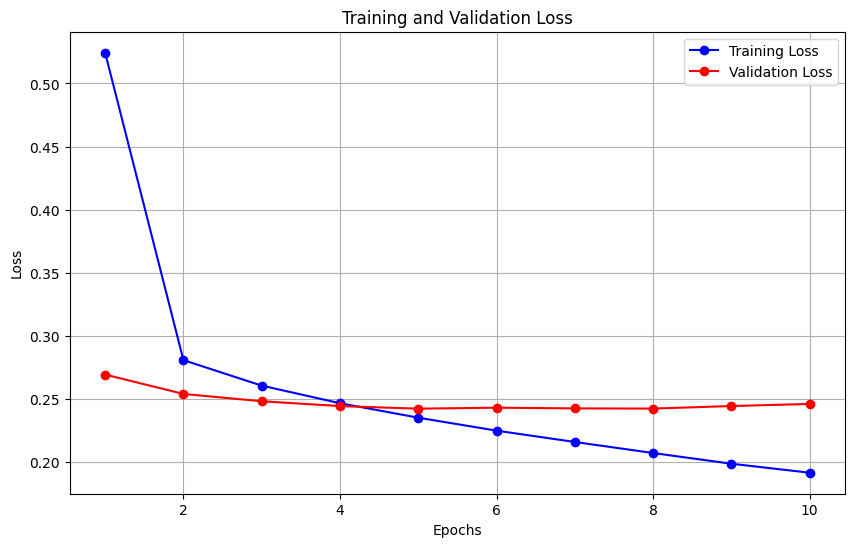

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='b', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='r', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import re


# Generate predictions and evaluate
model.eval()
predictions, references, inputs = [], [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Generate summary
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=150,
        min_length=30,
        num_beams=4,
        no_repeat_ngram_size=2
    )

    # Decode predictions and references, remove special tokens
    predictions.extend([re.sub(r"<extra_id_\d+>", "", tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)).strip()
                        for output in outputs])
    references.extend([tokenizer.decode(label, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                       for label in batch['labels']])
    inputs.extend([tokenizer.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                   for input_id in input_ids])

# Create a DataFrame to store inputs, predictions, and references
df_results = pd.DataFrame({
    'input': inputs,
    'references': references,
    'predictions': predictions
})
df_results.to_csv('generated_summaries1_indot5.csv', index=False)




In [ ]:
# Evaluasi ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

for ref, pred in zip(references, predictions):
    score = scorer.score(ref, pred)
    rouge_scores["rouge1"].append(score["rouge1"].fmeasure)
    rouge_scores["rouge2"].append(score["rouge2"].fmeasure)
    rouge_scores["rougeL"].append(score["rougeL"].fmeasure)

avg_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"])
avg_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"])
avg_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"])

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")

# Evaluasi BERTScore
P, R, F1 = bert_score(predictions, references, lang="en")
print(f"Average BERTScore Precision: {P.mean().item()}")
print(f"Average BERTScore Recall: {R.mean().item()}")
print(f"Average BERTScore F1: {F1.mean().item()}")

Average ROUGE-1: 0.43882495485273226
Average ROUGE-2: 0.2952317826792874
Average ROUGE-L: 0.4018151993430279


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8703164458274841
Average BERTScore Recall: 0.890876054763794
Average BERTScore F1: 0.8803143501281738


In [ ]:
import pandas as pd
import re


# Generate predictions and evaluate
model.eval()
predictions, references, inputs = [], [], []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Generate summary
    outputs = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        min_length=30,
        max_length=150,
        num_beams=10,
        no_repeat_ngram_size=2,
        repetition_penalty=3.0,
        length_penalty=1.2,
        early_stopping=True,
        use_cache=True,
        do_sample=True,
        temperature=1.0,
        top_k=50,
        top_p=0.9
    )

    # Decode predictions and references, remove special tokens
    predictions.extend([re.sub(r"<extra_id_\d+>", "", tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)).strip()
                        for output in outputs])
    references.extend([tokenizer.decode(label, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                       for label in batch['labels']])
    inputs.extend([tokenizer.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                   for input_id in input_ids])

# Create a DataFrame to store inputs, predictions, and references
df_results = pd.DataFrame({
    'input': inputs,
    'references': references,
    'predictions': predictions
})
df_results.to_csv('generated_summaries2_indot5.csv', index=False)




In [ ]:
# Evaluasi ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}

for ref, pred in zip(references, predictions):
    score = scorer.score(ref, pred)
    rouge_scores["rouge1"].append(score["rouge1"].fmeasure)
    rouge_scores["rouge2"].append(score["rouge2"].fmeasure)
    rouge_scores["rougeL"].append(score["rougeL"].fmeasure)

avg_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"])
avg_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"])
avg_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"])

print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")

# Evaluasi BERTScore
P, R, F1 = bert_score(predictions, references, lang="en")
print(f"Average BERTScore Precision: {P.mean().item()}")
print(f"Average BERTScore Recall: {R.mean().item()}")
print(f"Average BERTScore F1: {F1.mean().item()}")

Average ROUGE-1: 0.4266494850204733
Average ROUGE-2: 0.2826254909596367
Average ROUGE-L: 0.38945232022491805


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore Precision: 0.8710520267486572
Average BERTScore Recall: 0.8854697942733765
Average BERTScore F1: 0.8780692219734192


In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login

# Login dengan token Hugging Face
login(token="")

In [ ]:
from huggingface_hub import create_repo

# Membuat repository
repo_name = 'clean-model-indo-t5-10epoch-lower'
create_repo(repo_name)

RepoUrl('https://huggingface.co/intanutami/clean-model-indo-t5-10epoch-lower', endpoint='https://huggingface.co', repo_type='model', repo_id='intanutami/clean-model-indo-t5-10epoch-lower')

In [ ]:
from huggingface_hub import upload_folder

# Upload model ke repository yang sudah ada
upload_folder(
    repo_id='intanutami/clean-model-indo-t5-10epoch-lower',
    folder_path='/kaggle/working/clean_indot5_model_lower',
    commit_message="Upload my trained model"
)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/intanutami/clean-model-indo-t5-10epoch-lower/commit/d50a9efd2643dfb5590e4ac8393aed6444c5cf86', commit_message='Upload my trained\xa0model', commit_description='', oid='d50a9efd2643dfb5590e4ac8393aed6444c5cf86', pr_url=None, repo_url=RepoUrl('https://huggingface.co/intanutami/clean-model-indo-t5-10epoch-lower', endpoint='https://huggingface.co', repo_type='model', repo_id='intanutami/clean-model-indo-t5-10epoch-lower'), pr_revision=None, pr_num=None)